# Setup

In [1]:
import glob 
import sys, os
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sys.path.append('../../dataset/')
import dataset_utils

%load_ext autoreload
%autoreload 2

In [3]:
from platform import python_version

print(python_version())

3.6.10


In [4]:
def absolute_value(val,plot_df):
    return '{:.0f} Videos'.format(val * plot_df.T['Video Count'].sum() / 100)

def pct_value(val, plot_df=None):
    return '{:.2f}%'.format(val)

def select_top_tags_dfs(groups, top_groups, include_others=False):
    selected_dfs =[]
    names = []
    others = []
    for key, group in groups:
        if key in top_groups:
            selected_dfs.append(group)
            names.append(key)
        else:
            others.append(group)
    if include_others:
        selected_dfs.append(pd.concat(others,axis='rows'))
        names.append('Others')
    return selected_dfs, names

In [5]:
cols_dtypes = {
                'filename': str,
                'parentdir': str,
                'filesize': int,
                'video_duration_secs': float,
                'name': str,
                'tags': str,
                'main_tag': str,                                                                
               }
index_df = pd.read_csv('./dataset_index.csv',dtype=cols_dtypes)
index_df.head()

,filename,parentdir,filesize,video_duration_secs,name,tags,main_tag,macroclass,microclass
0,1005611,hard_porn,21380,397.480,Big boobed blonde babe fucked in boots and corset,"pussy,fucking,blonde,milf,shaved,busty,boots,f...",blonde,sensitive,pornography
1,10056205,hard_porn,18216,315.040,Lara Latex a012,"stockings,lesbian,european,milf,blowjob,brunet...",stockings,sensitive,pornography
2,10057030,hard_porn,30632,569.400,Anal sex in shiny latex lingerie and high heels,"anal,stockings,redhead,lingerie,latex,fetish,h...",lingerie,sensitive,pornography
3,10057628,hard_porn,78648,494.121,More than Messy FC Euro babes,"food,wet,oil,massage,messy,kinky,wam",oiled,sensitive,pornography
4,10062786,hard_porn,35084,220.268,latex body suit cant contain this booty,"ass,booty,latex,striptease,pawg,spandex,twerk,...",big_ass,sensitive,pornography


In [6]:
index_df.shape

(127075, 9)

In [7]:
improper, proper, porn, gore = dataset_utils.get_macro_and_micro_classes_df(index_df)

# Dataset checks

## Duplicates

To remove duplicates (same video diff uploader/id) i used fdupes.


https://unix.stackexchange.com/questions/71176/find-duplicate-files



Some videos such as https://www.youtube.com/watch?v=rpHWtcyd4Xg were both in "pool_party" and "UFC"

In [8]:
dupes = index_df.duplicated(['filename'])
assert (dupes.sum() == 0), 'Dataset has duplicates!'

## Columns with null values

In [9]:
assert (index_df['filesize'].isnull().sum()) == 0, 'All files must have a size!'

In [10]:
'Any collumns with null values? Files have no lenght!', index_df.isnull().any()

('Any collumns with null values? Files have no lenght!',
 filename               False
 parentdir              False
 filesize               False
 video_duration_secs    False
 name                    True
 tags                    True
 main_tag               False
 macroclass             False
 microclass             False
 dtype: bool)

# Dataset Statistics

## Overall dataset stats

### Videos

In [11]:
print('Total dataset:', len(index_df))
print('Total size (calculated individually):', dataset_utils.sizeof_fmt((index_df['filesize'].dropna().astype(int)).sum()))
print('Total duration of videos (calculated indiviadually):',dataset_utils.seconds_fmt(index_df['video_duration_secs'].sum()))
print('Improper videos:', len(improper))
print('Total size (calculated individually):', dataset_utils.sizeof_fmt((improper['filesize'].dropna().astype(int)).sum()))
print('Total duration of videos (calculated indiviadually):',dataset_utils.seconds_fmt(improper['video_duration_secs'].sum()))
print('Proper videos:', len(proper))
print('Total size (calculated individually):', dataset_utils.sizeof_fmt((proper['filesize'].dropna().astype(int)).sum()))
print('Total duration of videos (calculated indiviadually):',dataset_utils.seconds_fmt(proper['video_duration_secs'].sum()))

Total dataset: 127075
Total size (calculated individually): 3.5TiB
Total duration of videos (calculated indiviadually): 11806:21:13
Improper videos: 67424
Total size (calculated individually): 1.2TiB
Total duration of videos (calculated indiviadually): 6953:27:41
Proper videos: 59651
Total size (calculated individually): 2.2TiB
Total duration of videos (calculated indiviadually): 4852:53:31


In [12]:
dataset_utils.seconds_fmt(proper['video_duration_secs'].mean())

'00:04:52'

In [13]:
plot_df = dataset_utils.statistics_gobbler([improper,proper], ['Sensitive', 'Safe'])
plot_df

,Sensitive,Safe
Video Count,67424,59651
Total Duration,6953:27:41,4852:53:31
Mean Duration,00:06:11,00:04:52
STD Duration,00:04:12,00:03:26
Max Duration,00:30:55,00:30:55
Min Duration,00:00:05,00:00:05
Total Size,1.2TiB,2.2TiB
Mean Size,19.3MiB,39.0MiB
STD Size,35.4MiB,42.3MiB
Tag coverage,63036,59651


#### Parentdir

In [14]:
index_df['parentdir'].value_counts()

porn_videos              54549
yt_videos                50988
hard_porn                10519
gore_videos               2356
amamentacao_videos         987
animation_videos           823
breastfeeding_videos       724
ufc_videos                 592
model_videos               541
pool_videos                526
gymnastics_videos          474
pool_party_videos          459
ecchi_videos               431
fisiculturismo_videos      426
boxing_videos              416
yoga_videos                368
animação_videos            348
anime_videos               337
surf_videos                321
MMA_videos                 314
swimming_videos            297
beach_videos               279
Name: parentdir, dtype: int64

#### Durations and filesizes

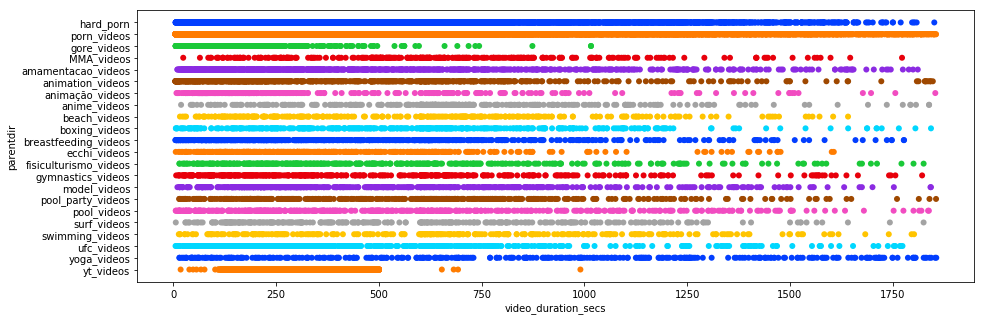

In [15]:
fig, ax = plt.subplots(figsize=(15,5))

g = sns.scatterplot(x="video_duration_secs", y='parentdir', data=index_df, ax=ax, hue="parentdir", palette="bright",linewidth=0)#style="parentdir"
g.legend_.remove()
#sns.color_palette("bright")
#plt.xticks(rotation=90)
#plt.set_xticklabels(rotation=90)
plt.show()

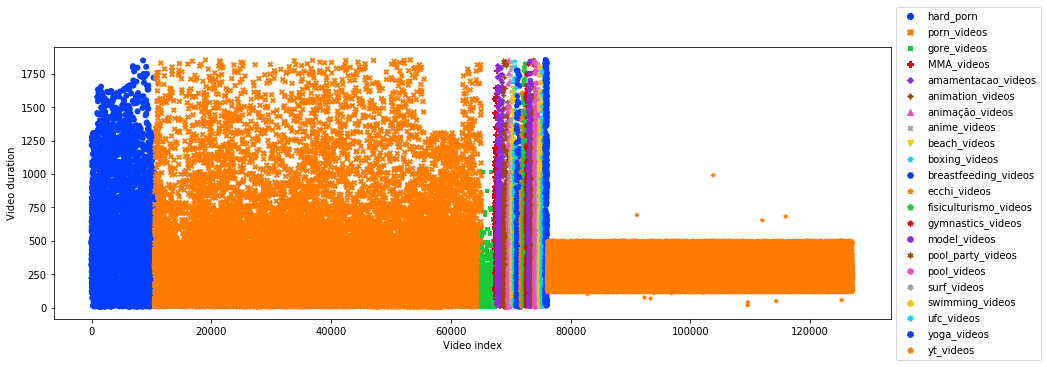

In [16]:
fig, ax = plt.subplots(figsize=(15,5))

g = sns.scatterplot(x=index_df.index, y="video_duration_secs", data=index_df, hue="parentdir", ax=ax, palette="bright", style="parentdir",linewidth=0)
#Put the right labels
plt.xlabel("Video index")
plt.ylabel("Video duration")
# Put the legend out of the figure
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))

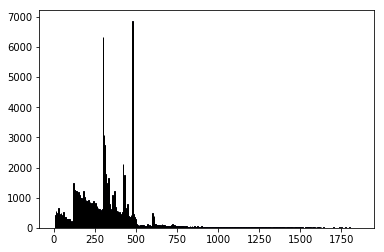

In [17]:
_ = plt.hist(index_df['video_duration_secs'], color = 'blue', edgecolor = 'black', bins = 500)
plt.show()

## Granular CSVs

In [18]:
#improper, proper, porn, gore = dataset_utils.get_macro_and_micro_classes_df(index_df)
        
porn = porn.reset_index(drop=True)
proper = proper.reset_index(drop=True)
gore = gore.reset_index(drop=True)

In [19]:
granular_stats_df = dataset_utils.statistics_gobbler([porn,gore,proper], ['Porn', 'Gore', 'YouTube'])
granular_stats_df

,Porn,Gore,YouTube
Video Count,65068,2356,59651
Total Duration,6900:17:38,53:10:02,4852:53:31
Mean Duration,00:06:21,00:01:21,00:04:52
STD Duration,00:04:10,00:01:26,00:03:26
Max Duration,00:30:55,00:16:56,00:30:55
Min Duration,00:00:05,00:00:05,00:00:05
Total Size,1.2TiB,15.8GiB,2.2TiB
Mean Size,19.8MiB,6.9MiB,39.0MiB
STD Size,35.9MiB,13.9MiB,42.3MiB
Tag coverage,63036,0,59651


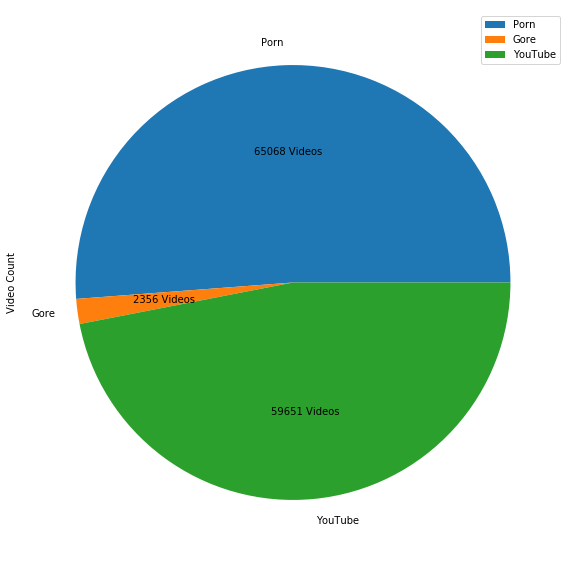

In [20]:
a = granular_stats_df.T.plot.pie(y='Video Count', autopct=lambda x: absolute_value(x, granular_stats_df), figsize=(10, 10))

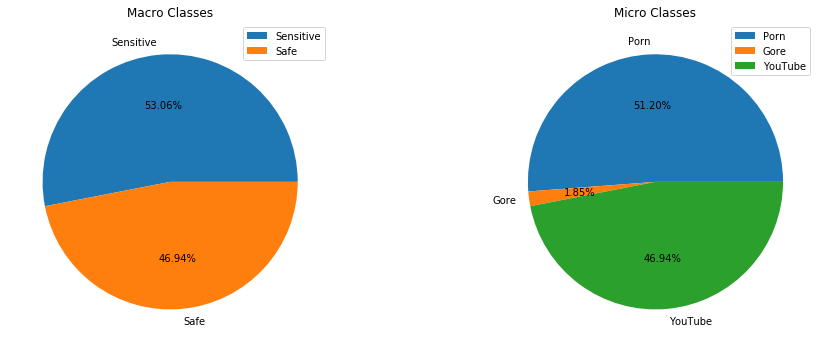

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

a = plot_df.T.plot.pie(y='Video Count', ax=axes[0],  autopct=lambda x: pct_value(x, plot_df), title= 'Macro Classes')
a.set_ylabel('')
#plt.title('Macro Classes',loc="center")

a = granular_stats_df.T.plot.pie(y='Video Count', ax=axes[1],  autopct=lambda x: pct_value(x, granular_stats_df), title= 'Micro Classes')
a.set_ylabel('')
#plt.title('Micro Classes',loc="center")

plt.tight_layout()
plt.show()

## Porn Statistics

In [22]:
porn['parentdir'].value_counts()

porn_videos    54549
hard_porn      10519
Name: parentdir, dtype: int64

In [23]:
porn['main_tag'].unique()

array(['blonde', 'stockings', 'lingerie', 'oiled', 'big_ass', 'milf',
       'lesbian', 'teen', 'Unknown', 'blowjob', 'sex_toys', 'anal',
       'bdsm', 'heels', 'cumshot', 'big_tits', 'squirting', 'sexy', 'ass',
       'amateur', 'exotic', 'solo_-_masturbation', 'bukkake', 'redhead',
       'toons', 'asian_woman', 'cam_porn', 'feet', 'big_cock',
       'shaved_pussy', 'mature', 'brunette', 'interracial', 'gangbang',
       'pissing', 'real_amateur', 'creampie', 'orgy', 'latina', 'fisting',
       'facial', 'gapes', 'bbw', 'familial_relations', 'pornstar',
       'virtual_reality', 'sex_dolls', 'arab', 'massage',
       'fucked_up_family', 'black_woman', 'japanese', 'celebrity',
       'hard_porn', 'ass_to_mouths', 'gay', 'bi_sexual', 'swingers',
       'shemale', 'workout', 'indian', 'asmr'], dtype=object)

In [24]:
grouped_porn = porn.groupby('main_tag')

In [25]:
n_tops = 5
porn['main_tag'].value_counts()[:n_tops]#.index[0]

gay          20604
teen         18303
blowjob       4197
cumshot       2333
hard_porn     1947
Name: main_tag, dtype: int64

In [26]:
porn['main_tag'].value_counts()[n_tops:].sum()

17684

In [27]:
def select_top_tags_dfs(groups, top_groups, include_others=False):
    selected_dfs =[]
    names = []
    others = []
    for key, group in groups:
        if key in top_groups:
            selected_dfs.append(group)
            names.append(key)
        else:
            others.append(group)
    if include_others:
        selected_dfs.append(pd.concat(others,axis='rows'))
        names.append('Others')
    return selected_dfs, names

In [28]:
selected_dfs, names = select_top_tags_dfs(grouped_porn, porn['main_tag'].value_counts()[:n_tops], include_others=True)

In [29]:
porn_stats_df = dataset_utils.statistics_gobbler(selected_dfs, names)
porn_stats_df

,blowjob,cumshot,gay,hard_porn,teen,Others
Video Count,4197,2333,20604,1947,18303,17684
Total Duration,503:44:56,348:27:39,1888:35:01,256:37:28,1922:49:21,1980:03:11
Mean Duration,00:07:12,00:08:57,00:05:29,00:07:54,00:06:18,00:06:43
STD Duration,00:03:00,00:06:34,00:03:26,00:04:26,00:03:20,00:05:08
Max Duration,00:29:46,00:30:42,00:30:55,00:30:51,00:30:50,00:30:54
Min Duration,00:00:06,00:00:05,00:00:05,00:00:07,00:00:05,00:00:05
Total Size,88.5GiB,66.6GiB,170.7GiB,116.0GiB,312.9GiB,501.3GiB
Mean Size,21.6MiB,29.2MiB,8.5MiB,61.0MiB,17.5MiB,29.0MiB
STD Size,22.7MiB,47.2MiB,10.2MiB,76.7MiB,27.7MiB,48.1MiB
Tag coverage,4197,2333,20604,0,18303,17599


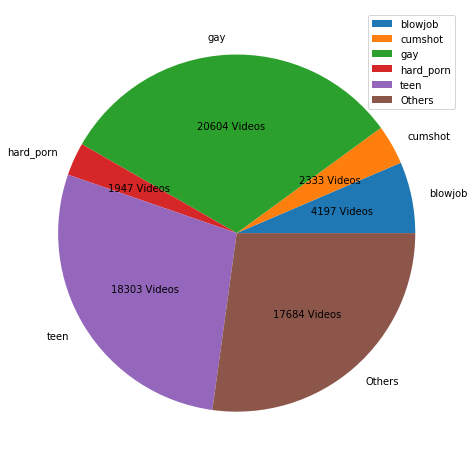

In [30]:
a = porn_stats_df.T.plot.pie(y='Video Count', autopct=lambda x: absolute_value(x, porn_stats_df), figsize=(8,10))
_ = a.set_ylabel('')

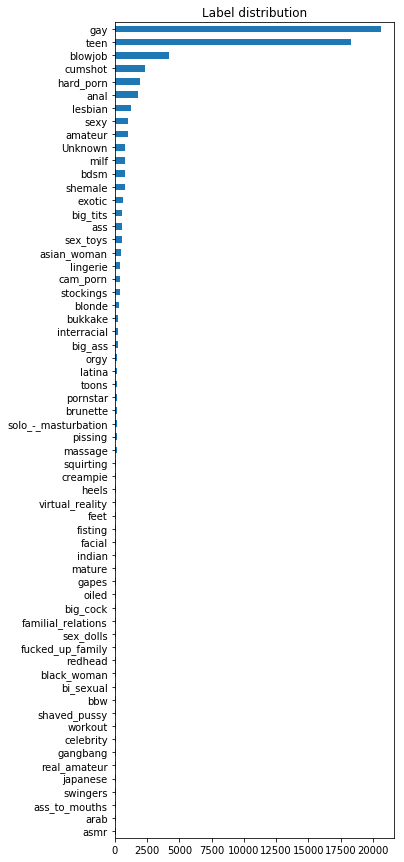

In [31]:
porn['main_tag'].value_counts().sort_values(ascending=True).plot.barh(title='Label distribution', figsize=(5,15))#, ax=axes[1]
plt.show()

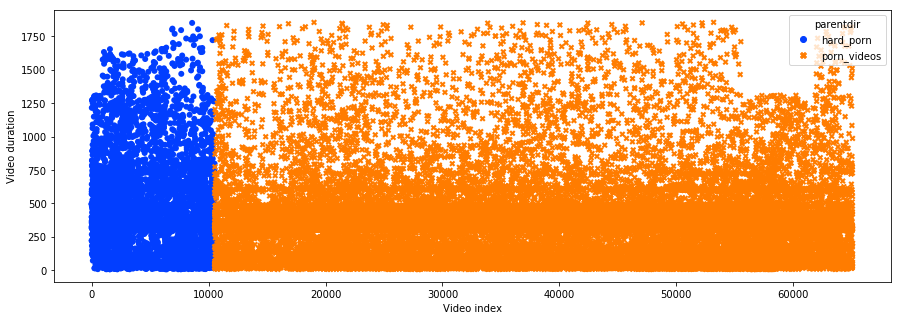

In [32]:
fig, ax = plt.subplots(figsize=(15,5))
sns.scatterplot(x=porn.index, y="video_duration_secs", data=porn, hue="parentdir", ax=ax, palette="bright", style="parentdir",linewidth=0)
#Put the right labels
plt.xlabel("Video index")
plt.ylabel("Video duration")
# Put the legend out of the figure
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))

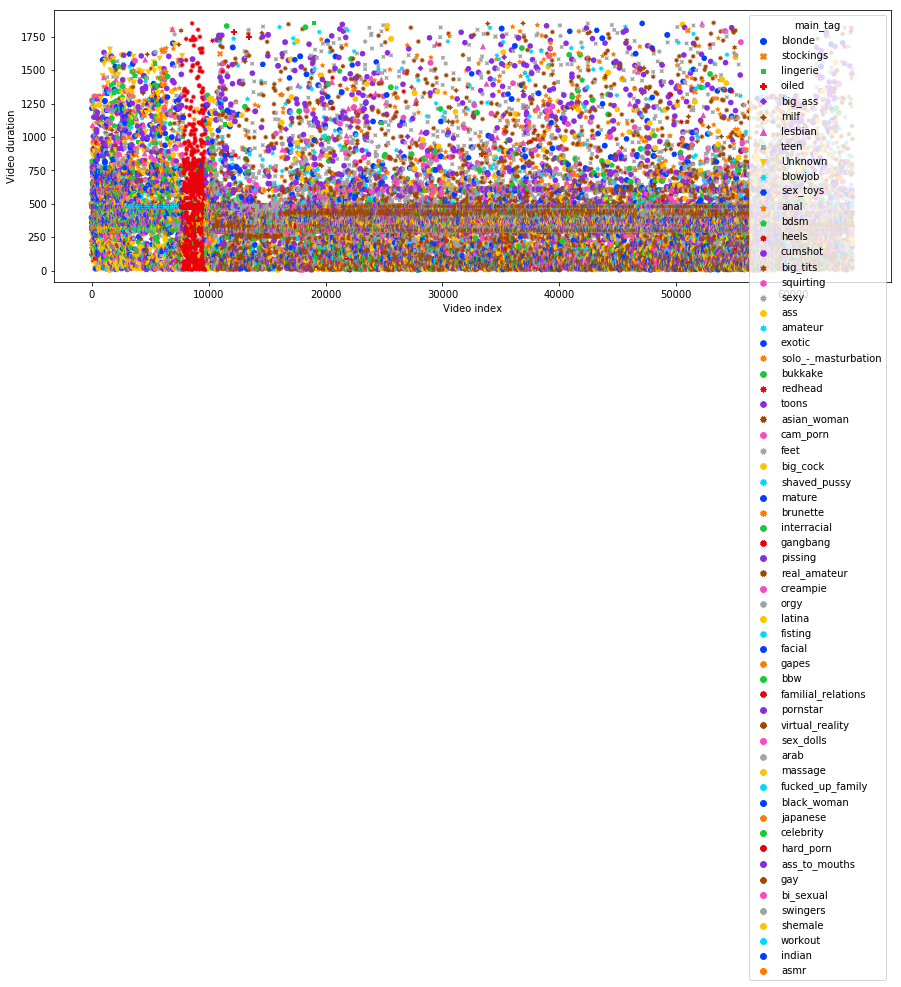

In [33]:
fig, ax = plt.subplots(figsize=(15,5))
sns.scatterplot(x=porn.index, y="video_duration_secs", data=porn, hue="main_tag", ax=ax, palette="bright", style="main_tag",linewidth=0)
#Put the right labels
plt.xlabel("Video index")
plt.ylabel("Video duration")
# Put the legend out of the figure
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))

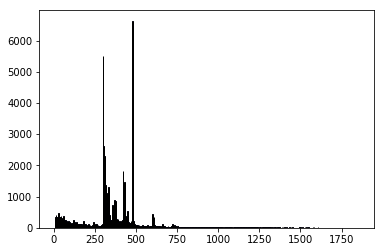

In [34]:
_ = plt.hist(porn['video_duration_secs'], color = 'blue', edgecolor = 'black', bins = 500)

In [35]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

/home/pedropva/.local/share/virtualenvs/VideoMR-1jFH6azx/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
grouped_porn = porn.groupby('main_tag')
selected_dfs, names = select_top_tags_dfs(grouped_porn, porn['main_tag'].value_counts(), include_others=False)
porn_stats_df = dataset_utils.statistics_gobbler(selected_dfs, names, short=False).T.sort_values(by='Video Count',ascending=False)
porn_stats_df

,Video Count,Total Duration,Mean Duration,STD Duration,Max Duration,Min Duration,Total Size,Mean Size,STD Size,Tag coverage,Tag coverage (%)
gay,20604,1888:35:01,00:05:29,00:03:26,00:30:55,00:00:05,170.7GiB,8.5MiB,10.2MiB,20604,100
teen,18303,1922:49:21,00:06:18,00:03:20,00:30:50,00:00:05,312.9GiB,17.5MiB,27.7MiB,18303,100
blowjob,4197,503:44:56,00:07:12,00:03:00,00:29:46,00:00:06,88.5GiB,21.6MiB,22.7MiB,4197,100
cumshot,2333,348:27:39,00:08:57,00:06:34,00:30:42,00:00:05,66.6GiB,29.2MiB,47.2MiB,2333,100
hard_porn,1947,256:37:28,00:07:54,00:04:26,00:30:51,00:00:07,116.0GiB,61.0MiB,76.7MiB,0,0
anal,1821,248:31:25,00:08:11,00:06:19,00:30:38,00:00:05,83.0GiB,46.6MiB,59.2MiB,1821,100
lesbian,1269,150:05:51,00:07:05,00:04:02,00:30:51,00:00:06,26.4GiB,21.3MiB,38.7MiB,1269,100
sexy,1058,112:49:57,00:06:23,00:05:03,00:30:48,00:00:05,19.9GiB,19.2MiB,37.3MiB,1058,100
amateur,1021,85:53:07,00:05:02,00:04:46,00:30:26,00:00:06,25.5GiB,25.5MiB,36.6MiB,1021,100
Unknown,816,100:20:01,00:07:22,00:06:16,00:30:00,00:00:05,43.9GiB,55.1MiB,90.8MiB,731,89.5833


## Gore Statistics

There are no subtags in Gore videos.

In [37]:
len(gore)

2356

In [38]:
gore_stats_df = dataset_utils.statistics_gobbler([gore], ['Gore'], short=True).T#.sort_values(by='Video Count',ascending=False)
gore_stats_df

,Video Count,Total Duration,Mean Duration,STD Duration,Total Size,Tag coverage (%)
Gore,2356,53:10:02,00:01:21,00:01:26,15.8GiB,0


In [39]:
gore['video_duration_secs'].describe(), gore['filesize'].describe()

(count    2356.000000
 mean     81.240621  
 std      86.451996  
 min      5.452000   
 25%      30.145000  
 50%      57.473500  
 75%      98.635500  
 max      1016.058000
 Name: video_duration_secs, dtype: float64, count    2356.000000  
 mean     7017.879457  
 std      14276.722076 
 min      164.000000   
 25%      1635.000000  
 50%      3380.000000  
 75%      7148.000000  
 max      375008.000000
 Name: filesize, dtype: float64)

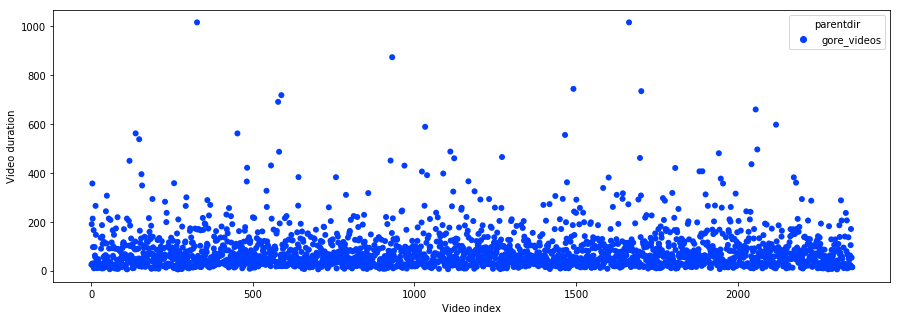

In [40]:
fig, ax = plt.subplots(figsize=(15,5))
sns.scatterplot(x=gore.index, y="video_duration_secs", data=gore, hue="parentdir", ax=ax, palette="bright", style="parentdir",linewidth=0)
#Put the right labels
plt.xlabel("Video index")
plt.ylabel("Video duration")
# Put the legend out of the figure
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))

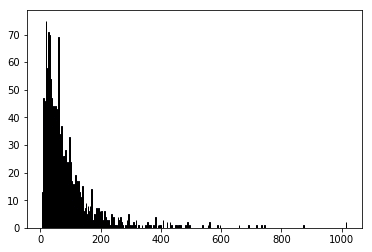

In [41]:
_ = plt.hist(gore['video_duration_secs'], color = 'blue', edgecolor = 'black', bins = 500)

## Youtube Statistics

Temporarily moving hard videos to tag

In [42]:
grouped_proper = proper.groupby('main_tag')

In [43]:
n_tops = 5
proper['main_tag'].value_counts()[:n_tops]

Hard Safe Videos        8640
Arts & Entertainment    8554
Games                   7182
Autos & Vehicles        6812
(Unknown)               4054
Name: main_tag, dtype: int64

In [44]:
print('Others:',proper['main_tag'].value_counts()[n_tops:].sum())

Others: 24409


Plots

In [45]:
selected_dfs, names = select_top_tags_dfs(grouped_proper, proper['main_tag'].value_counts()[:n_tops], include_others=True)

In [46]:
proper_stats_df = dataset_utils.statistics_gobbler(selected_dfs, names)
proper_stats_df

,(Unknown),Arts & Entertainment,Autos & Vehicles,Games,Hard Safe Videos,Others
Video Count,4054,8554,6812,7182,8640,24409
Total Duration,283:05:42,598:33:35,455:38:54,530:11:13,1278:28:34,1706:55:32
Mean Duration,00:04:11,00:04:11,00:04:00,00:04:25,00:08:52,00:04:11
STD Duration,00:01:37,00:01:36,00:01:39,00:01:47,00:06:46,00:01:41
Max Duration,00:08:19,00:11:32,00:08:19,00:16:30,00:30:55,00:08:19
Min Duration,00:01:58,00:01:58,00:00:48,00:00:39,00:00:05,00:00:17
Total Size,109.0GiB,221.5GiB,253.3GiB,250.6GiB,638.5GiB,801.9GiB
Mean Size,27.5MiB,26.5MiB,38.1MiB,35.7MiB,75.7MiB,33.6MiB
STD Size,25.4MiB,24.3MiB,29.0MiB,31.9MiB,79.5MiB,26.4MiB
Tag coverage,4054,8554,6812,7182,8640,24409


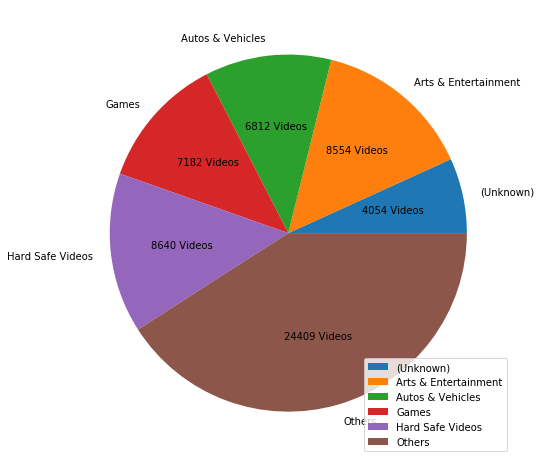

In [47]:
a = proper_stats_df.T.plot.pie(y='Video Count', autopct=lambda x: absolute_value(x, proper_stats_df), figsize=(8,10))
plt.legend(bbox_to_anchor=(1,0), loc="lower right")
_ = a.set_ylabel('')

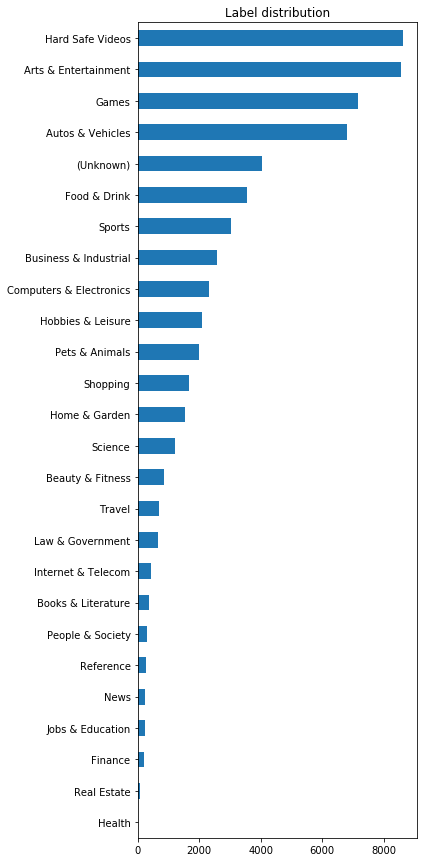

In [48]:
proper['main_tag'].value_counts().sort_values(ascending=True).plot.barh(title='Label distribution', figsize=(5,15))#, ax=axes[1]
plt.show()

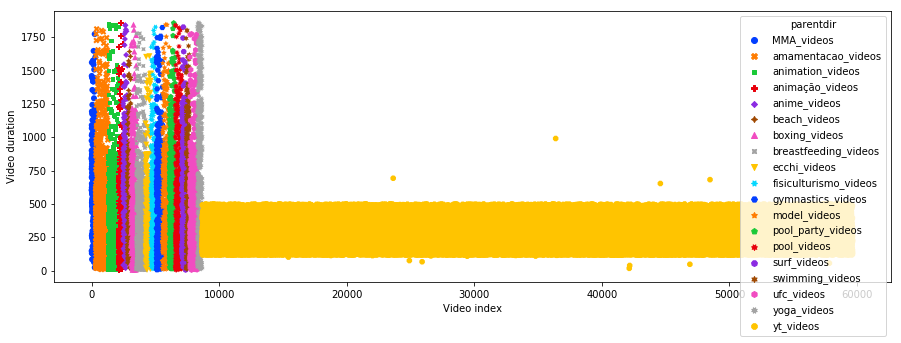

In [49]:
fig, ax = plt.subplots(figsize=(15,5))
sns.scatterplot(x=proper.index, y="video_duration_secs", data=proper, hue="parentdir", ax=ax, palette="bright", style="parentdir",linewidth=0)
#Put the right labels
plt.xlabel("Video index")
plt.ylabel("Video duration")
# Put the legend out of the figure
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))

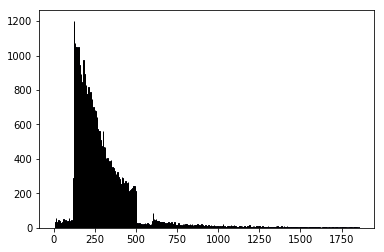

In [50]:
_ = plt.hist(proper['video_duration_secs'], color = 'blue', edgecolor = 'black', bins = 500)

Short stats

In [51]:
selected_dfs, names = select_top_tags_dfs(grouped_proper, proper['main_tag'].value_counts(), include_others=False)
proper_stats_df = dataset_utils.statistics_gobbler(selected_dfs, names, short=True).T.sort_values(by='Video Count',ascending=False)
proper_stats_df

,Video Count,Total Duration,Mean Duration,STD Duration,Total Size,Tag coverage (%)
Hard Safe Videos,8640,1278:28:34,00:08:52,00:06:46,638.5GiB,100
Arts & Entertainment,8554,598:33:35,00:04:11,00:01:36,221.5GiB,100
Games,7182,530:11:13,00:04:25,00:01:47,250.6GiB,100
Autos & Vehicles,6812,455:38:54,00:04:00,00:01:39,253.3GiB,100
(Unknown),4054,283:05:42,00:04:11,00:01:37,109.0GiB,100
Food & Drink,3552,262:25:03,00:04:25,00:01:42,129.2GiB,100
Sports,3053,203:38:24,00:04:00,00:01:38,100.4GiB,100
Business & Industrial,2584,182:38:23,00:04:14,00:01:43,83.1GiB,100
Computers & Electronics,2325,169:45:31,00:04:22,00:01:44,84.3GiB,100
Hobbies & Leisure,2110,149:44:31,00:04:15,00:01:44,77.1GiB,100
